# PPCA in PyStan

In this notebook, we try to perform a PPCA in Pystan.

In [86]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

Here, the model is defined in Stan. It is based on the original model as defined by Pierson (2015). Note that we make use of the logit-transformed bernoulli parametrization as it is numerically more stable on the given scale.

In [87]:
zifa = """

data{
    int<lower=0> N; // number  of  datapoints
    int<lower=0> D; // number  of  dimensions  in  observed  dataset
    int<lower=0> M; // number  of  dimensions  in  latent  dataset
    matrix[N,D] y; // zero inflated observations
}

parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] A;  // factor loadings
    vector<lower=0>[D] sigmas;   //  standard  deviations
    real<lower=0, upper=0.5> lambda; // zero-inflation
    vector[D] mu;   //  added means
    matrix[N,D] x; // non-inflated observations
}

transformed parameters{
    // means and covariacne matrix of z
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    
    for (n in 1:N){
        target+=multi_normal_lpdf(z[:,n]|mean_z,cov_z);
        for (d in 1:D){
            target+=normal_lpdf(x[n,d]|row(A,d)*col(z,n)+mu[d], sigmas[d]);
            if (y[n,d]==0){
                target+=bernoulli_logit_lpmf(1|-square(x[n,d])*lambda);
            } else {
                target+=bernoulli_logit_lpmf(0|-square(x[n,d])*lambda);
                target+=normal_lpdf(y[n,d]|row(A,d)*col(z,n)+mu[d], sigmas[d]);
            }
        }
    }
}
"""
zifa_model = pystan.StanModel(model_code=zifa)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6efc52f26401562c8431bfe3ca3278d NOW.


Note the log-probability in the 'model'-section of the code. We take $p(\sigma^2)$, $p(z)$ and $p(x|z)$ into account first. Then we take $p(h=1|x)$ or $p(h=0|x)$, depending on whether the datapoint is zero or non-zero. The reasoning behind this is given in the supplementary material of E. Pierson (2015). Unlike the original article, we also take $p(y|z,h)$ (which is $1$ is $h=1$) into account, to get a more accurate estimate of $z$, $A$ and $W$. We end up with a complete likelihood of $$\prod^N_{i=1}p(z_i)\Big(\prod_{j:y_{i,j}=0}p(x_{i,j}|z_i)p(h_{i,j}=1|x_{i,j})\prod_{j:y_{i,j}\neq}p(x_{i,j}|z_i)p(h_{i,j}=0|x_{i,j})\Big)$$

Note that our model does not take the prior distributions of $\mu$, $\sigma^2$ and $W$ into account, like the original model. This is because these parameters were chosen manually or came from uniform distributions in the original paper, leaving them with flat priors.

We specify our parameters as done in the original paper and generate some data.

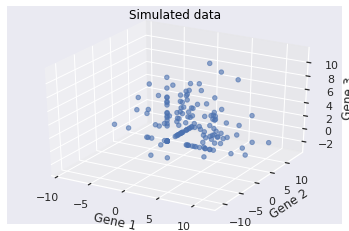

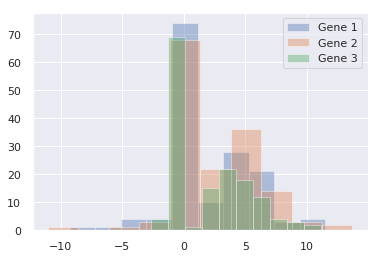

In [88]:
N=150
D=3
M=2

z = np.random.normal(0,1, size=(M,N))
mu = np.random.uniform(2.7,3.3,size=(D,1))
lamda = 0.1
sigma_A = 0.3
A = np.zeros((D,M))

for i in range(D):
    for j in range(M):
        if i==j:
            A[i,j] = np.random.uniform(.9*sigma_A,1.1*sigma_A)
        else:
            A[i,j] = np.random.uniform(-.5,.5)

            
W = np.random.uniform(2.7,3.3,size=(D,1))
x = np.random.normal(np.matmul(A,z)+mu,W).T
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.6)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y[:,0], alpha=0.4, label='Gene 1')
plt.hist(y[:,1], alpha=0.4, label='Gene 2')
plt.hist(y[:,2], alpha=0.4, label='Gene 3')
plt.legend()
plt.show()

And then we can optimize our parameters and latent dataset.

In [89]:
zifa_dat = {'N': N, 'D':D, 'M':M, 'y':y}
fit = zifa_model.sampling(data=zifa_dat, chains=1, iter=200)
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

In [90]:
z_sim = fit_ext['z'][best_ind]
mu_sim = fit_ext['mu'][best_ind]
W_sim = fit_ext['sigmas'][best_ind]
lambda_sim = fit_ext['lambda'][best_ind]
A_sim = fit_ext['A'][best_ind]

x_sim = fit_ext['x'][best_ind]
# x_sim = np.random.normal(np.matmul(z_sim.T,A_sim.T)+mu_sim,sigma_sim)    # or x can be recreated from z, W and sigma
h_sim = np.random.binomial(n=1, p=1-np.exp(-(x_sim**2)*lambda_sim))
y_sim = x_sim*h_sim

print('real mu: ', mu.T)
print('simulated mu: ', mu_sim)
print()
print('real W: ', W[:,0])
print('simulated W: ', W_sim)
print()
print('real lambda: ', lamda)
print('simulated lambda: ', lambda_sim)
print()
print('real AA^T:\n', np.matmul(A,A.T))
print('simulated AA^T:\n', np.matmul(A_sim,A_sim.T))
print()

real mu:  [[2.74491013 3.22958881 3.06813319]]
simulated mu:  [3.56871164 4.43555274 4.21444021]

real W:  [3.05669905 3.26577575 2.89126229]
simulated W:  [1.17679802 3.12519371 1.27413787]

real lambda:  0.1
simulated lambda:  0.011218239581357703

real AA^T:
 [[ 0.15211012 -0.19590884 -0.06389307]
 [-0.19590884  0.25533604  0.10430766]
 [-0.06389307  0.10430766  0.18751001]]
simulated AA^T:
 [[15.82249968  9.39411986 -1.93549425]
 [ 9.39411986  6.573028   -3.05611197]
 [-1.93549425 -3.05611197  3.88952163]]



In [91]:
print('Real mean of x: ',np.mean(x, axis=0))
print('Simulated mean of x: ',np.mean(x_sim, axis=0))
print()
print('Real cov. matrix of x:\n',np.cov(x.T))
print('Simulated cov. matrix of x:\n',np.cov(x_sim.T))
print()
print('Real mean of z: ',np.mean(z, axis=1))
print('Simulated mean of z: ',np.mean(z_sim, axis=1))
print()
print('Real cov. matrix of z:\n',np.cov(z))
print('Simulated cov. matrix of z:\n',np.cov(z_sim))

Real mean of x:  [2.60185275 3.0578138  2.9847683 ]
Simulated mean of x:  [3.46679101 4.7048829  4.16489754]

Real cov. matrix of x:
 [[10.62060253  1.33010036  0.24575043]
 [ 1.33010036 10.28102157 -0.38508999]
 [ 0.24575043 -0.38508999  6.46600596]]
Simulated cov. matrix of x:
 [[16.39962275  8.55648435 -1.16702649]
 [ 8.55648435 16.13154998 -3.25366886]
 [-1.16702649 -3.25366886  5.14381771]]

Real mean of z:  [0.05907495 0.05057746]
Simulated mean of z:  [-0.03674638 -0.01512064]

Real cov. matrix of z:
 [[1.09354306 0.0495268 ]
 [0.0495268  1.04042062]]
Simulated cov. matrix of z:
 [[1.02988469 0.04417903]
 [0.04417903 0.84336822]]


The result is plotted below. The result starts to look like the original, but $\lambda$ is biased towards more zero-inflation. Our $\bar{x}$ values also tend to have higher values than the original.

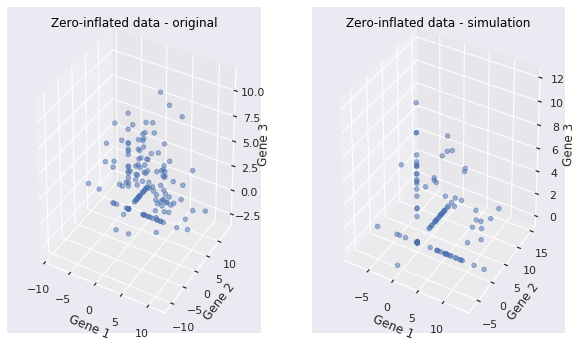

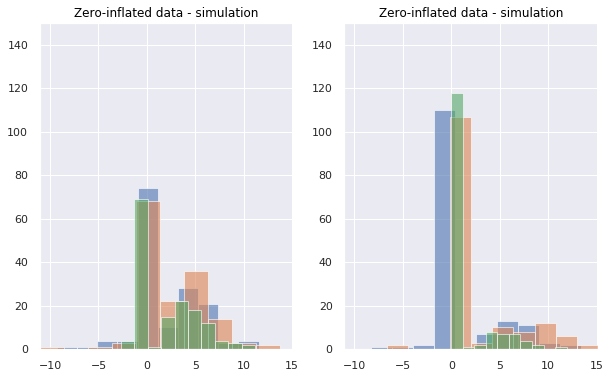

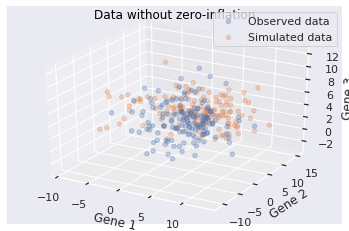

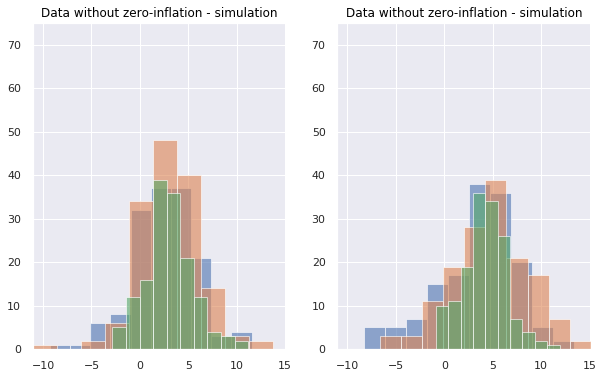

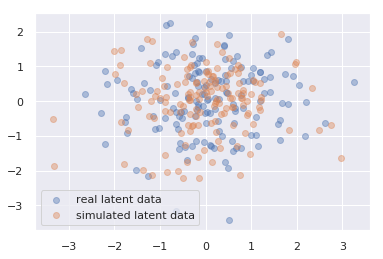

In [92]:
sns.set()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.5)
title = ax.set_title("Zero-inflated data - original")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(y_sim[:,0],y_sim[:,1],y_sim[:,2], label='Simulated data', alpha=0.5)
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(y[:,0], alpha=0.6)
ax.hist(y[:,1], alpha=0.6)
ax.hist(y[:,2], alpha=0.6)
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
ax.set_ylim((0,N))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(y_sim[:,0], alpha=0.6)
ax.hist(y_sim[:,1], alpha=0.6)
ax.hist(y_sim[:,2], alpha=0.6)
ax.set_ylim((0,N))
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Data without zero-inflation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(x[:,0], alpha=0.6)
ax.hist(x[:,1], alpha=0.6)
ax.hist(x[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(x_sim[:,0], alpha=0.6)
ax.hist(x_sim[:,1], alpha=0.6)
ax.hist(x_sim[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_sim[0,:], z_sim[1,:], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()


## ZI-PPCA

In [93]:
zippca = """

data{
    int<lower=0> N; // number  of  datapoints
    int<lower=0> D; // number  of  dimensions  in  observed  dataset
    int<lower=0> M; // number  of  dimensions  in  latent  dataset
    matrix[N,D] y; // zero inflated observations
}

parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] A;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    real<lower=0, upper=0.5> lambda; // zero-inflation
    vector[D] mu;   //  added means
    matrix[N,D] x; // non-inflated observations
}

transformed parameters{
    // means and covariacne matrix of z
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    
    for (n in 1:N){
        target+=multi_normal_lpdf(z[:,n]|mean_z,cov_z);
        for (d in 1:D){
            target+=normal_lpdf(x[n,d]|row(A,d)*col(z,n)+mu[d], sigma);
            if (y[n,d]==0){
                target+=bernoulli_logit_lpmf(1|-square(x[n,d])*lambda);
            } else {
                target+=bernoulli_logit_lpmf(0|-square(x[n,d])*lambda);
                target+=normal_lpdf(y[n,d]|row(A,d)*col(z,n)+mu[d], sigma);
            }
        }
    }
}
"""
zippca_model = pystan.StanModel(model_code=zippca)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_296d2f5d48a7fb20d655e7b6fbf6d268 NOW.


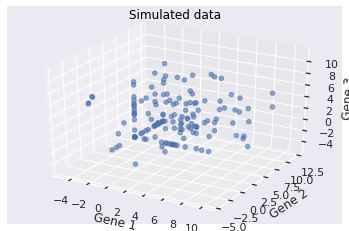

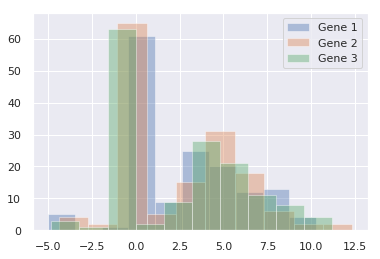

In [94]:
N=150
D=3
M=2

z = np.random.normal(0,1, size=(M,N))
mu = np.random.uniform(2.7,3.3,size=(D,1))
lamda = 0.1
sigma_A = 0.3
A = np.zeros((D,M))

for i in range(D):
    for j in range(M):
        if i==j:
            A[i,j] = np.random.uniform(.9*sigma_A,1.1*sigma_A)
        else:
            A[i,j] = np.random.uniform(-.5,.5)

            
sigma = np.random.uniform(2.7,3.3)
x = np.random.normal(np.matmul(A,z)+mu,sigma).T
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.6)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y[:,0], alpha=0.4, label='Gene 1')
plt.hist(y[:,1], alpha=0.4, label='Gene 2')
plt.hist(y[:,2], alpha=0.4, label='Gene 3')
plt.legend()
plt.show()

And then we can optimize our parameters and latent dataset.

In [95]:
zippca_dat = {'N': N, 'D':D, 'M':M, 'y':y}
fit = zippca_model.sampling(data=zippca_dat, chains=1, iter=200, verbose=True)
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

In [96]:
z_sim = fit_ext['z'][best_ind]
mu_sim = fit_ext['mu'][best_ind]
sigma_sim = fit_ext['sigma'][best_ind]
lambda_sim = fit_ext['lambda'][best_ind]
A_sim = fit_ext['A'][best_ind]

x_sim = fit_ext['x'][best_ind]
# x_sim = np.random.normal(np.matmul(z_sim.T,A_sim.T)+mu_sim,sigma_sim)    # or x can be recreated from z, W and sigma
h_sim = np.random.binomial(n=1, p=1-np.exp(-(x_sim**2)*lambda_sim))
y_sim = x_sim*h_sim

print('real mu: ', mu.T)
print('simulated mu: ', mu_sim)
print()
print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim)
print()
print('real lambda: ', lamda)
print('simulated lambda: ', lambda_sim)
print()
print('real AA^T:\n', np.matmul(A,A.T))
print('simulated AA^T:\n', np.matmul(A_sim,A_sim.T))
print()

real mu:  [[2.93585367 2.83659754 2.97011916]]
simulated mu:  [4.40338546 4.74756232 4.62627354]

real sigma:  3.225572793889958
simulated sigma:  2.193634999122473

real lambda:  0.1
simulated lambda:  0.01386430300909941

real AA^T:
 [[ 0.1354385  -0.02876824 -0.09071407]
 [-0.02876824  0.17152441  0.01823667]
 [-0.09071407  0.01823667  0.06076495]]
simulated AA^T:
 [[ 3.51045978  1.17531713  2.10242229]
 [ 1.17531713  4.89692161 -2.17623   ]
 [ 2.10242229 -2.17623     3.10111193]]



In [97]:
print('Real mean of x: ',np.mean(x, axis=0))
print('Simulated mean of x: ',np.mean(x_sim, axis=0))
print()
print('Real cov. matrix of x:\n',np.cov(x.T))
print('Simulated cov. matrix of x:\n',np.cov(x_sim.T))
print()
print('Real mean of z: ',np.mean(z, axis=1))
print('Simulated mean of z: ',np.mean(z_sim, axis=1))
print()
print('Real cov. matrix of z:\n',np.cov(z))
print('Simulated cov. matrix of z:\n',np.cov(z_sim))

Real mean of x:  [3.01268147 3.07850956 3.25203341]
Simulated mean of x:  [4.70823292 4.81595948 4.76820592]

Real cov. matrix of x:
 [[10.50508916  0.42196673  1.46397583]
 [ 0.42196673  8.73726784 -0.27426727]
 [ 1.46397583 -0.27426727 10.723741  ]]
Simulated cov. matrix of x:
 [[ 6.09751108  0.36785957  1.8478638 ]
 [ 0.36785957 10.18107154 -2.55137843]
 [ 1.8478638  -2.55137843  7.03567535]]

Real mean of z:  [-0.01644946  0.14501701]
Simulated mean of z:  [-0.03856289 -0.03002985]

Real cov. matrix of z:
 [[ 0.93123913 -0.04998864]
 [-0.04998864  0.9594709 ]]
Simulated cov. matrix of z:
 [[ 0.76851513 -0.05765449]
 [-0.05765449  0.77075935]]


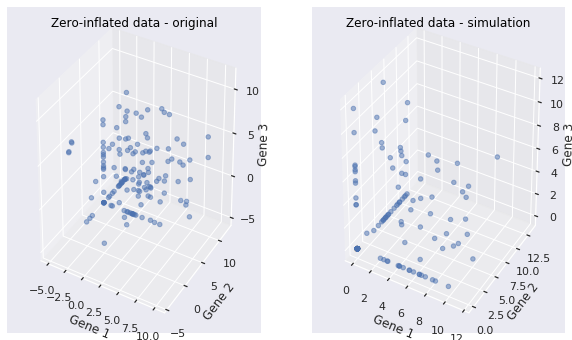

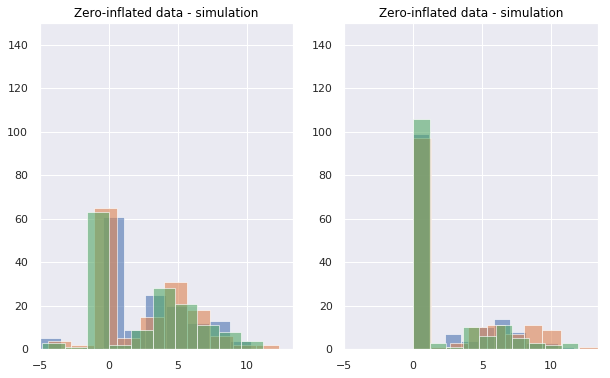

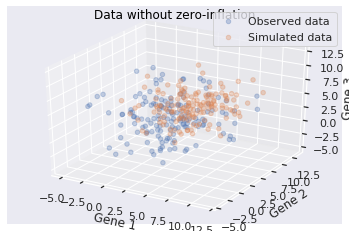

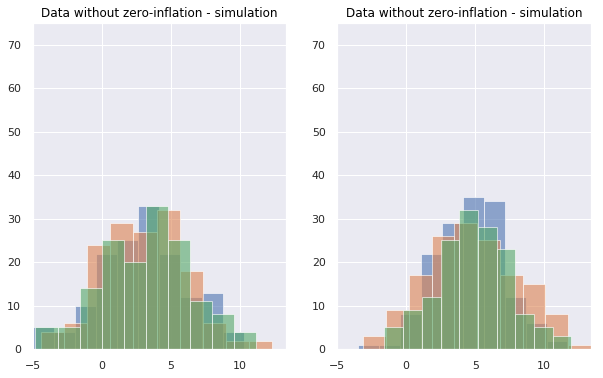

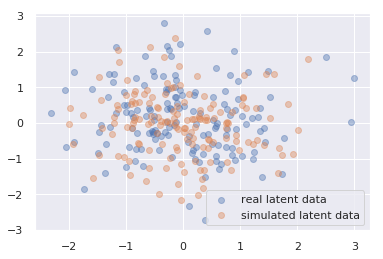

In [98]:
sns.set()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.5)
title = ax.set_title("Zero-inflated data - original")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(y_sim[:,0],y_sim[:,1],y_sim[:,2], label='Simulated data', alpha=0.5)
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(y[:,0], alpha=0.6)
ax.hist(y[:,1], alpha=0.6)
ax.hist(y[:,2], alpha=0.6)
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
ax.set_ylim((0,N))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(y_sim[:,0], alpha=0.6)
ax.hist(y_sim[:,1], alpha=0.6)
ax.hist(y_sim[:,2], alpha=0.6)
ax.set_ylim((0,N))
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Data without zero-inflation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(x[:,0], alpha=0.6)
ax.hist(x[:,1], alpha=0.6)
ax.hist(x[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(x_sim[:,0], alpha=0.6)
ax.hist(x_sim[:,1], alpha=0.6)
ax.hist(x_sim[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_sim[0,:], z_sim[1,:], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()
